In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "Dof"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn014701,MPPETSDRRPARMQNDGAHPPEPEQLPCPRCESTNTKFCYYNNYNL...,225,1
1,Achn040131,MNFSSIPAYLDPSNWQQQAPNPQTEGGNGSGSSSQLPQPPPQAPTH...,321,1
2,Achn050591,MQDPSTYQQIQPQFPEHEHLKCPRCDSTNTKFCYYNNYNLSQPRHY...,184,1
3,Achn058491,MEHKGLVPVLVLFLGFSFVLSCVAVPTSRSGPFSLVERNQFESPFL...,573,1
4,Achn091101,MIQELLGETSLIGGERKISLSNILEASSSLSPSPSPSPSSSSSAQE...,305,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
4623,0.024887,0.002262,0.000000,0.002262,0.002262,0.009050,0.002262,0.000000,0.002262,0.009050,...,0.004525,0.000000,0.0,0.000000,0.002262,0.000000,0.000000,0.004525,0.000000,0.004525
5749,0.009050,0.001810,0.001810,0.001810,0.000905,0.003620,0.001810,0.002715,0.000000,0.004525,...,0.002715,0.002715,0.0,0.000905,0.000905,0.001810,0.000905,0.000000,0.000000,0.000000
6485,0.014745,0.002681,0.004021,0.010054,0.000000,0.004692,0.000000,0.004692,0.004021,0.002681,...,0.000670,0.003351,0.0,0.001340,0.000000,0.002011,0.000000,0.000000,0.000000,0.003351
198,0.014663,0.002933,0.000000,0.002933,0.000000,0.000000,0.000000,0.002933,0.002933,0.008798,...,0.005865,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.005865,0.000000,0.000000
10453,0.037037,0.009259,0.000000,0.009259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.009259,0.000000,0.009259,0.000000,0.009259,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (9024, 441)
X_test: (2257, 441)
y_train: (9024,)
y_test: (2257,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 53s 475ms/step - accuracy: 0.4375 - loss: 0.6934

 35/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7067 - loss: 0.6680   

 68/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7832 - loss: 0.5835

100/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8228 - loss: 0.5046

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8351 - loss: 0.4770 - val_accuracy: 0.9895 - val_loss: 0.0402


Epoch 2/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0250

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0494

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0463

 89/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0435

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0426 - val_accuracy: 0.9878 - val_loss: 0.0415


Epoch 3/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9844 - loss: 0.0241

 31/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0320

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0307

 89/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0296

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0291 - val_accuracy: 0.9945 - val_loss: 0.0206


Epoch 4/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0041

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0163

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0186

 89/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0202

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0213 - val_accuracy: 0.9917 - val_loss: 0.0279


Epoch 5/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0103

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0200

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0177

 89/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0175

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0173 - val_accuracy: 0.9939 - val_loss: 0.0192


Epoch 6/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0096

 61/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0132

 92/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0134

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0132 - val_accuracy: 0.9961 - val_loss: 0.0172


Epoch 7/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0070

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0079

 88/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0088

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0093 - val_accuracy: 0.9823 - val_loss: 0.0640


Epoch 8/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.0740

 31/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0199

 61/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0153

 89/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0140

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0137 - val_accuracy: 0.9956 - val_loss: 0.0175


Epoch 9/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0024

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0146

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0144

 90/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0135

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0128 - val_accuracy: 0.9928 - val_loss: 0.0246


Epoch 10/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0072

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0086

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0125

 87/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0151

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0156 - val_accuracy: 0.9961 - val_loss: 0.0165


Epoch 11/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4662e-04

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0062    

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0076

 90/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0084

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0085 - val_accuracy: 0.9956 - val_loss: 0.0171


Epoch 12/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016

 29/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0055

 57/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0060

 86/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0078

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0093 - val_accuracy: 0.9956 - val_loss: 0.0179


Epoch 13/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0020

 31/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0038

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0050

 88/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0067

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0087 - val_accuracy: 0.9939 - val_loss: 0.0223


Epoch 14/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.2742e-04

 30/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0064    

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0076

 89/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0084

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0084 - val_accuracy: 0.9956 - val_loss: 0.0174


Epoch 15/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0053

 31/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0019

 61/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0028

 91/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0043

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0051 - val_accuracy: 0.9922 - val_loss: 0.0248


Epoch 16/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013

 29/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0097

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0106

 87/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0102

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0096 - val_accuracy: 0.9928 - val_loss: 0.0303



[Train Accuracy: 99.81% - Test Accuracy: 99.16%]


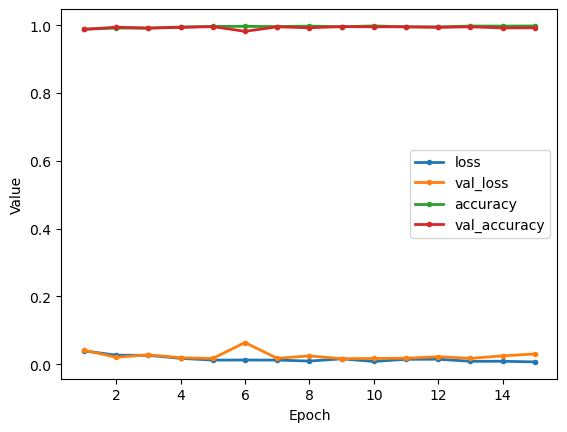

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step


 1/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
4623,0.006803,0.000000,0.000000,0.000000,0.0,0.002268,0.000000,0.000000,0.000000,0.002268,...,0.002268,0.0,0.0,0.0,0.002268,0.000000,0.0,0.0,0.0,0.0
5749,0.002717,0.000000,0.000000,0.000906,0.0,0.000000,0.000906,0.000906,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
6485,0.002012,0.000000,0.000671,0.003353,0.0,0.000671,0.000000,0.000671,0.002683,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.001341,0.0,0.0,0.0,0.0
198,0.005882,0.000000,0.000000,0.002941,0.0,0.000000,0.000000,0.002941,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
10453,0.009346,0.009346,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (9024, 8915)
X_test: (2257, 8915)
y_train: (9024,)
y_test: (2257,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,282,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,325,761 (8.87 MB)

 Trainable params: 2,325,761 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 59s 531ms/step - accuracy: 0.4844 - loss: 0.6931

  9/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4989 - loss: 0.6930   

 17/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5674 - loss: 0.6917

 25/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6279 - loss: 0.6888

 33/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6719 - loss: 0.6831

 41/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7052 - loss: 0.6733

 50/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7343 - loss: 0.6560

 59/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7576 - loss: 0.6337

 67/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7747 - loss: 0.6119

 75/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7893 - loss: 0.5897

 83/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8018 - loss: 0.5683

 92/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8139 - loss: 0.5457

100/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8234 - loss: 0.5269

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8328 - loss: 0.5070

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8375 - loss: 0.4966 - val_accuracy: 0.9956 - val_loss: 0.0192


Epoch 2/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0099

  9/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0124 

 18/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9984 - loss: 0.0110

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0106

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0110

 45/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0113

 54/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0116

 63/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0117

 72/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0117

 81/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0116

 90/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0117

 99/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0119

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0119

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9972 - loss: 0.0120 - val_accuracy: 0.9972 - val_loss: 0.0126


Epoch 3/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0014

 10/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0024 

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0027

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0028

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0027

 45/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0026

 54/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0026

 63/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0026

 72/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0026

 81/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0026

 89/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0026

 98/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0025

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0025

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 0.9972 - val_loss: 0.0115


Epoch 4/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0020

  9/113 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014 

 17/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

 35/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

 44/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

 68/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

 76/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

 84/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010

102/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0010

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.9769e-04 - val_accuracy: 0.9967 - val_loss: 0.0165


Epoch 5/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.6729e-04

  9/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7378e-04 

 17/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9111e-04

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8415e-04

 35/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7588e-04

 44/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7127e-04

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6816e-04

 61/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6640e-04

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6367e-04

 79/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6167e-04

 88/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6056e-04

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5929e-04

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5791e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5656e-04 - val_accuracy: 0.9972 - val_loss: 0.0165


Epoch 6/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.0086e-04

  9/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3641e-04 

 17/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2405e-04

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0395e-04

 34/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8993e-04

 43/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7858e-04

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6941e-04

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6188e-04

 69/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5482e-04

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4913e-04

 87/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4426e-04

 95/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4058e-04

103/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3725e-04

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3424e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.3361e-04 - val_accuracy: 0.9967 - val_loss: 0.0176


Epoch 7/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.5246e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1036e-04 

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6767e-04

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4668e-04

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2975e-04

 44/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1864e-04

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1149e-04

 61/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0735e-04

 69/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0396e-04

 77/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0094e-04

 85/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8630e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6603e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4652e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2621e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.1897e-05 - val_accuracy: 0.9967 - val_loss: 0.0184


Epoch 8/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.5987e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5735e-05 

 18/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.2312e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9308e-05

 35/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5813e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2802e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0310e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7842e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7541e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8456e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9270e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0972e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2094e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2751e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.3020e-05 - val_accuracy: 0.9967 - val_loss: 0.0194


Epoch 9/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.2685e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7849e-05 

 18/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7468e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7330e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6461e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5841e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7042e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7569e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7798e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7834e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7910e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7857e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7639e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7367e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.7309e-05 - val_accuracy: 0.9972 - val_loss: 0.0192


Epoch 10/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.1981e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4749e-05 

 18/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7776e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8375e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8274e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7920e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7697e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7472e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7239e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7175e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7131e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7047e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6918e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6815e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.6785e-05 - val_accuracy: 0.9967 - val_loss: 0.0219


Epoch 11/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.8782e-04

 10/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9029e-05 

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0513e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2005e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7296e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4318e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1834e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0079e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8613e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7213e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6025e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5153e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4381e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3734e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.3580e-05 - val_accuracy: 0.9967 - val_loss: 0.0214


Epoch 12/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.1011e-06

 10/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1589e-06 

 19/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5043e-06

 27/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7477e-06

 36/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9101e-06

 45/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0571e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0896e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0952e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0995e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0956e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0875e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0772e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0683e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0564e-05 - val_accuracy: 0.9967 - val_loss: 0.0231



[Train Accuracy: 100.00% - Test Accuracy: 99.82%]


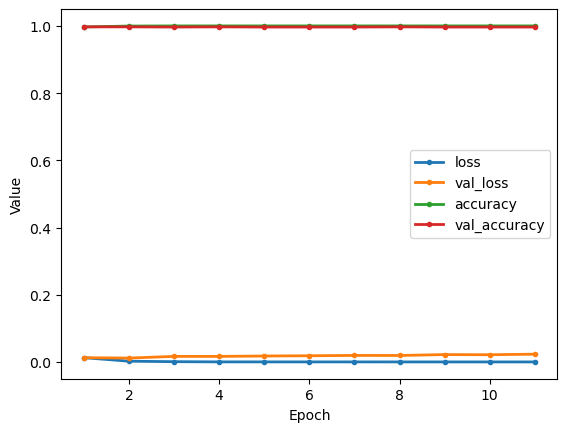

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

61/71 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 1/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

64/71 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
4623,0.002273,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5749,0.000907,0.0,0.000000,0.0,0.0,0.000000,0.000907,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6485,0.000671,0.0,0.000671,0.0,0.0,0.000671,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.002950,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10453,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      39,403,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,444,481 (150.47 MB)

 Trainable params: 39,444,481 (150.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:15 672ms/step - accuracy: 0.4688 - loss: 0.6931

  2/113 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.4883 - loss: 0.6931 

  3/113 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.4939 - loss: 0.6931

  4/113 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.4935 - loss: 0.6931

  5/113 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.4954 - loss: 0.6931

  6/113 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.5005 - loss: 0.6931

  7/113 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.5052 - loss: 0.6930

  8/113 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.5126 - loss: 0.6930

  9/113 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.5172 - loss: 0.6929

 10/113 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.5210 - loss: 0.6928

 11/113 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.5234 - loss: 0.6927

 12/113 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.5257 - loss: 0.6927

 13/113 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.5275 - loss: 0.6926

 14/113 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.5284 - loss: 0.6925

 15/113 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.5295 - loss: 0.6924

 16/113 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.5320 - loss: 0.6923

 17/113 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.5355 - loss: 0.6921

 18/113 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.5398 - loss: 0.6920

 19/113 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.5447 - loss: 0.6918

 20/113 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.5499 - loss: 0.6917

 21/113 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.5554 - loss: 0.6915

 22/113 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.5611 - loss: 0.6913

 23/113 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.5668 - loss: 0.6911

 24/113 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5725 - loss: 0.6908

 25/113 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5783 - loss: 0.6905

 26/113 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5840 - loss: 0.6902

 27/113 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5897 - loss: 0.6899

 28/113 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.5952 - loss: 0.6896

 29/113 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.6007 - loss: 0.6892

 30/113 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.6060 - loss: 0.6888 

 31/113 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.6111 - loss: 0.6884

 32/113 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.6162 - loss: 0.6879

 33/113 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.6212 - loss: 0.6874

 34/113 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.6261 - loss: 0.6869

 35/113 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.6308 - loss: 0.6863

 36/113 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6355 - loss: 0.6857

 37/113 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6400 - loss: 0.6850

 38/113 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6445 - loss: 0.6843

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6488 - loss: 0.6835

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.6529 - loss: 0.6827

 41/113 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6570 - loss: 0.6818

 42/113 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6610 - loss: 0.6809

 43/113 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6649 - loss: 0.6799

 44/113 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6687 - loss: 0.6789

 45/113 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6724 - loss: 0.6777

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.6760 - loss: 0.6766

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.6796 - loss: 0.6753

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.6830 - loss: 0.6740

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.6864 - loss: 0.6727

 50/113 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.6897 - loss: 0.6713

 51/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.6929 - loss: 0.6698

 52/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.6960 - loss: 0.6682

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.6991 - loss: 0.6666

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.7020 - loss: 0.6650

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.7050 - loss: 0.6632

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.7078 - loss: 0.6614

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.7106 - loss: 0.6596

 58/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7133 - loss: 0.6577

 59/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7160 - loss: 0.6557

 60/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7186 - loss: 0.6537

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7211 - loss: 0.6517

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7236 - loss: 0.6496

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7261 - loss: 0.6474

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7285 - loss: 0.6453

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7308 - loss: 0.6431

 66/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7331 - loss: 0.6408

 67/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7354 - loss: 0.6386

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7376 - loss: 0.6363

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7398 - loss: 0.6340

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7419 - loss: 0.6316

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7440 - loss: 0.6293

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7461 - loss: 0.6269

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7481 - loss: 0.6245

 74/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7501 - loss: 0.6222

 75/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7520 - loss: 0.6198

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7539 - loss: 0.6174

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7558 - loss: 0.6150

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7577 - loss: 0.6125

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7595 - loss: 0.6101

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7613 - loss: 0.6077

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.7630 - loss: 0.6053

 82/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7647 - loss: 0.6029

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7664 - loss: 0.6004

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7681 - loss: 0.5980

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7698 - loss: 0.5956

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7714 - loss: 0.5933

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7729 - loss: 0.5909

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7745 - loss: 0.5885

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7760 - loss: 0.5861

 90/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7776 - loss: 0.5838

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7791 - loss: 0.5814

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7805 - loss: 0.5791

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7820 - loss: 0.5768

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.7834 - loss: 0.5745

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.7848 - loss: 0.5722

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.7862 - loss: 0.5699

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.7875 - loss: 0.5676

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7889 - loss: 0.5653

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7902 - loss: 0.5631

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7915 - loss: 0.5609

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7928 - loss: 0.5586

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7941 - loss: 0.5564

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7953 - loss: 0.5542

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7965 - loss: 0.5521

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.7978 - loss: 0.5499

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7990 - loss: 0.5477

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8001 - loss: 0.5456

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8013 - loss: 0.5435

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8024 - loss: 0.5414

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8036 - loss: 0.5393

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8047 - loss: 0.5372

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8058 - loss: 0.5351

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8069 - loss: 0.5331

113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.8080 - loss: 0.5311 - val_accuracy: 0.9972 - val_loss: 0.0156


Epoch 2/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 25s 231ms/step - accuracy: 1.0000 - loss: 0.0072

  2/113 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 1.0000 - loss: 0.0069

  3/113 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 0.0067

  4/113 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 0.0066

  5/113 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 0.0065

  6/113 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 0.0063

  7/113 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 0.0062

  8/113 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 0.0061

  9/113 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 0.0060

 10/113 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 1.0000 - loss: 0.0059

 11/113 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9999 - loss: 0.0061

 12/113 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.9998 - loss: 0.0063

 13/113 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.9997 - loss: 0.0064

 14/113 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.9996 - loss: 0.0065

 15/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9996 - loss: 0.0065

 16/113 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.9996 - loss: 0.0066

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.9995 - loss: 0.0066

 18/113 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9995 - loss: 0.0065

 19/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.9995 - loss: 0.0065

 20/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.9995 - loss: 0.0065

 21/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.9994 - loss: 0.0065

 22/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.9994 - loss: 0.0065

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9994 - loss: 0.0065

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9993 - loss: 0.0065

 25/113 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9993 - loss: 0.0065

 26/113 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9993 - loss: 0.0065

 27/113 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9993 - loss: 0.0064

 28/113 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9992 - loss: 0.0064

 29/113 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9992 - loss: 0.0064

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9992 - loss: 0.0064

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9991 - loss: 0.0064

 32/113 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9991 - loss: 0.0064

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9991 - loss: 0.0064

 34/113 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9990 - loss: 0.0064

 35/113 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9990 - loss: 0.0064

 36/113 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9990 - loss: 0.0064

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9990 - loss: 0.0064

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9989 - loss: 0.0064

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9989 - loss: 0.0064 

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9989 - loss: 0.0065

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9989 - loss: 0.0065

 42/113 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9989 - loss: 0.0065

 43/113 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9988 - loss: 0.0065

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9988 - loss: 0.0065

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9988 - loss: 0.0064

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9988 - loss: 0.0064

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9988 - loss: 0.0064

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9988 - loss: 0.0064

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9988 - loss: 0.0064

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9988 - loss: 0.0064

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9988 - loss: 0.0064

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9988 - loss: 0.0064

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9988 - loss: 0.0064

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9988 - loss: 0.0064

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9988 - loss: 0.0063

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9988 - loss: 0.0063

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9987 - loss: 0.0063

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9987 - loss: 0.0063

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9987 - loss: 0.0063

 60/113 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9987 - loss: 0.0063

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9987 - loss: 0.0063

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9987 - loss: 0.0063

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9987 - loss: 0.0063

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9987 - loss: 0.0063

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9987 - loss: 0.0062

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9987 - loss: 0.0062

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9987 - loss: 0.0062

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9987 - loss: 0.0062

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 75/113 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9987 - loss: 0.0062

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 90/113 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9987 - loss: 0.0061

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9987 - loss: 0.0060

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9987 - loss: 0.0060

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9987 - loss: 0.0060

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9987 - loss: 0.0060

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9987 - loss: 0.0060

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9987 - loss: 0.0060

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9987 - loss: 0.0060

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9987 - loss: 0.0060

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9987 - loss: 0.0060

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9987 - loss: 0.0060

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9987 - loss: 0.0060

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9987 - loss: 0.0060

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9987 - loss: 0.0060

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9987 - loss: 0.0060

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9987 - loss: 0.0060

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9987 - loss: 0.0060

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9987 - loss: 0.0060

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.9987 - loss: 0.0060 - val_accuracy: 0.9972 - val_loss: 0.0086


Epoch 3/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 1.0000 - loss: 9.0703e-04

  2/113 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 1.0000 - loss: 0.0010    

  3/113 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 0.0010

  4/113 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 0.0010

  5/113 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 0.0010

  6/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 0.0010

  7/113 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 1.0000 - loss: 9.9554e-04

  8/113 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 0.0010    

  9/113 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0010

 10/113 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 0.0010

 11/113 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 0.0010

 12/113 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 0.0010

 13/113 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 0.0010

 14/113 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 0.0010

 15/113 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 0.0010

 16/113 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 0.0010

 17/113 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 0.0010

 18/113 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 0.0010

 19/113 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 0.0010

 20/113 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 0.0010

 21/113 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 0.0010

 22/113 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 0.0010

 23/113 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 0.0010

 24/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 0.0010

 25/113 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 9.9938e-04

 26/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 9.9555e-04

 27/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 9.9409e-04

 28/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 9.9214e-04

 29/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 9.8985e-04

 30/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 9.8727e-04

 31/113 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 9.8439e-04

 32/113 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 9.8140e-04

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 9.7899e-04

 34/113 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 9.7682e-04

 35/113 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 9.7544e-04

 36/113 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 9.7374e-04

 37/113 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 9.7184e-04

 38/113 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 9.6984e-04

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 9.6785e-04 

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 9.6598e-04

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 9.6396e-04

 42/113 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 9.6203e-04

 43/113 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 9.6007e-04

 44/113 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 9.5793e-04

 45/113 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 9.5586e-04

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 9.5373e-04

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 9.5149e-04

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 9.4910e-04

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 9.4671e-04

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 9.4428e-04

 51/113 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 9.4202e-04

 52/113 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 9.3985e-04

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 9.3768e-04

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 9.3544e-04

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 9.3332e-04

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 9.3112e-04

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 9.2896e-04

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 9.2674e-04

 59/113 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 9.2445e-04

 60/113 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 9.2210e-04

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 9.1975e-04

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 9.1745e-04

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 9.1513e-04

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 9.1278e-04

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 9.1049e-04

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 9.0831e-04

 67/113 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 9.0617e-04

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 9.0404e-04

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 9.0193e-04

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 8.9979e-04

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 8.9764e-04

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 8.9554e-04

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 8.9343e-04

 74/113 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 8.9128e-04

 75/113 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.8918e-04

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.8707e-04

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.8498e-04

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.8287e-04

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 8.8076e-04

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 8.7863e-04

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 8.7649e-04

 82/113 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 8.7435e-04

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.7222e-04

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.7008e-04

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.6793e-04

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.6577e-04

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.6360e-04

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.6146e-04

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.5933e-04

 90/113 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.5723e-04

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.5516e-04

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.5316e-04

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.5117e-04

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.4924e-04

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.4736e-04

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.4549e-04

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 8.4369e-04

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.4189e-04

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.4010e-04

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.3831e-04

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.3652e-04

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.3476e-04

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.3301e-04

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.3130e-04

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 8.2960e-04

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.2790e-04

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.2620e-04

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.2451e-04

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.2282e-04

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.2119e-04

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.1961e-04

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.1803e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.1646e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 1.0000 - loss: 8.1491e-04 - val_accuracy: 0.9967 - val_loss: 0.0120


Epoch 4/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 26s 233ms/step - accuracy: 1.0000 - loss: 4.2006e-04

  2/113 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 4.1201e-04

  3/113 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 3.8488e-04

  4/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 3.6116e-04

  5/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 3.4893e-04

  6/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 3.3836e-04

  7/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 3.3201e-04

  8/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 3.2903e-04

  9/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 3.2589e-04

 10/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 3.2258e-04

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 3.2105e-04

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 3.1945e-04

 13/113 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 3.1773e-04

 14/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 3.1623e-04

 15/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 3.1517e-04

 16/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 3.1391e-04

 17/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 3.1239e-04

 18/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 3.1310e-04

 19/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 3.1387e-04

 20/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 3.1428e-04

 21/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 3.1446e-04

 22/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 3.1430e-04

 23/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 3.1420e-04

 24/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 3.1377e-04

 25/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 3.1328e-04

 26/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 3.1282e-04

 27/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1233e-04

 28/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1199e-04

 29/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1159e-04

 30/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1120e-04

 31/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1071e-04

 32/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1028e-04

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.0975e-04

 34/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0915e-04 

 35/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.0856e-04

 36/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.0801e-04

 37/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.0737e-04

 38/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0670e-04

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0605e-04

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0537e-04

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.0471e-04

 42/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0471e-04

 43/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0469e-04

 44/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0458e-04

 45/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0445e-04

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0427e-04

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0403e-04

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0382e-04

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0358e-04

 50/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0340e-04

 51/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0318e-04

 52/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0290e-04

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0258e-04

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0226e-04

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0193e-04

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0161e-04

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.0128e-04

 58/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.0111e-04

 59/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.0090e-04

 60/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.0074e-04

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.0055e-04

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.0033e-04

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.0011e-04

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.9987e-04

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.9962e-04

 66/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.9938e-04

 67/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.9917e-04

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.9911e-04

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.9901e-04

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.9901e-04

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.9897e-04

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.9890e-04

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.9880e-04

 74/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9869e-04

 75/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9855e-04

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9838e-04

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9822e-04

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9804e-04

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9784e-04

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9766e-04

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9745e-04

 82/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9722e-04

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9699e-04

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9674e-04

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9650e-04

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9628e-04

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9605e-04

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9581e-04

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9557e-04

 90/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9531e-04

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9504e-04

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9477e-04

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9449e-04

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9420e-04

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9392e-04

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9362e-04

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9332e-04

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.9302e-04

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.9271e-04

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.9240e-04

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.9209e-04

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.9176e-04

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.9143e-04

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.9109e-04

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.9075e-04

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.9040e-04

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.9005e-04

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.8969e-04

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.8934e-04

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.8898e-04

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8861e-04

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8824e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8787e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 2.8750e-04 - val_accuracy: 0.9967 - val_loss: 0.0133


Epoch 5/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 29s 263ms/step - accuracy: 1.0000 - loss: 7.2445e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 8.7978e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 8.9354e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 8.9070e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 8.8259e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 8.6789e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 8.7155e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 8.7621e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 8.8034e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 8.8678e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 8.8911e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 8.9086e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 8.9144e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 8.9105e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 8.9547e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 8.9999e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 9.0619e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 9.1029e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.1505e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.1921e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.2164e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.2389e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.2529e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.3046e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.3531e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.3943e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.4520e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.5006e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.7720e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.0071e-04

 31/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.0368e-04

 32/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.0632e-04

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.0867e-04

 34/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.1077e-04 

 35/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.1265e-04

 36/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.1434e-04

 37/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.1587e-04

 38/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.1730e-04

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.1858e-04

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.1996e-04

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.2123e-04

 42/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.2260e-04

 43/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.2388e-04

 44/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.2504e-04

 45/113 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.2612e-04

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.2713e-04

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.2806e-04

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.2892e-04

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.2970e-04

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.3042e-04

 51/113 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.3109e-04

 52/113 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.3172e-04

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.3229e-04

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.3283e-04

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.3332e-04

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.3382e-04

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.3427e-04

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.3470e-04

 59/113 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.3516e-04

 60/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.3559e-04

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.3599e-04

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.3636e-04

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.3673e-04

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.3706e-04

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.3735e-04

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.3762e-04

 67/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3786e-04

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3810e-04

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3832e-04

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3851e-04

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3868e-04

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3882e-04

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3893e-04

 74/113 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3902e-04

 75/113 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3910e-04

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3916e-04

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3921e-04

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3924e-04

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3927e-04

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.3928e-04

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.3928e-04

 82/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3926e-04

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3923e-04

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3919e-04

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3914e-04

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3913e-04

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3911e-04

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3908e-04

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.3904e-04

 90/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3899e-04

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3893e-04

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3887e-04

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3881e-04

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3875e-04

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3869e-04

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3864e-04

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.3857e-04

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3854e-04

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3850e-04

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3845e-04

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3844e-04

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3842e-04

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3840e-04

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3837e-04

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.3832e-04

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3828e-04

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3823e-04

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3818e-04

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3812e-04

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3807e-04

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.3801e-04

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3795e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3788e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 1.0000 - loss: 1.3782e-04 - val_accuracy: 0.9967 - val_loss: 0.0123


Epoch 6/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 32s 288ms/step - accuracy: 1.0000 - loss: 5.4782e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 6.3307e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 6.3258e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 6.1267e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 5.9636e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 5.9796e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 5.9153e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 5.8293e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 5.7577e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 5.7029e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 5.6483e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 5.6204e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 5.5827e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 5.5376e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 5.4892e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 5.4502e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 5.4138e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 5.3738e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 5.3316e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 5.2938e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 5.2569e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 5.2225e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 5.1943e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 5.1667e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 5.1872e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 5.2016e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 5.2105e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 5.2148e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 5.2172e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 5.2159e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 5.2133e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 5.2077e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 5.2014e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.1935e-05 

 35/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.1849e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.1750e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.1655e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.1550e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.1455e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.1375e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.1284e-05

 42/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.1216e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.1133e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.1046e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.0955e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.0862e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.0760e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.0671e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.0573e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.0471e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.0367e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.0255e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.0178e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.0095e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.0016e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.9932e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.9851e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.9779e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.9704e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.9625e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.9553e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.9480e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.9415e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.9351e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.9323e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.9291e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.9271e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.9266e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.9255e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.9239e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.9221e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.9208e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.9192e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.9172e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.9149e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.9125e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.9097e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.9098e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.9097e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.9117e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 4.9133e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.9144e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.9149e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.9152e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.9155e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.9161e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.9163e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.9161e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 4.9156e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.9148e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.9136e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.9215e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.9290e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.9359e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.9422e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.9480e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.9534e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.9584e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.9637e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.9686e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.9731e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.9771e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.9807e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.9846e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.9880e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.9911e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.9938e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.9963e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.9987e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0010e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0030e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0048e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 5.0063e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 1.0000 - loss: 5.0079e-05 - val_accuracy: 0.9967 - val_loss: 0.0132


Epoch 7/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 42s 379ms/step - accuracy: 1.0000 - loss: 1.6609e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 1.0000 - loss: 1.6811e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 2.4176e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 2.6211e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.0259e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 4.3524e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 5.1226e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 5.5768e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 5.8891e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 6.0766e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 6.1845e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 6.2449e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 6.2840e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 6.2914e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 6.2827e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 6.2612e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 6.2268e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 6.1992e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.1626e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.1211e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.0736e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.0249e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 5.9742e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 5.9378e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 5.8982e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 5.8562e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 5.8122e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 5.7690e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 5.7246e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 5.6840e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 5.6434e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 5.6104e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 5.5770e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 5.5429e-05 

 35/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 5.5085e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 5.4743e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.4400e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.4053e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.3706e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.3360e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 5.3025e-05

 42/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.2689e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.2405e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.2123e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.1852e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.1580e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.1324e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.1101e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 5.0877e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 5.0651e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 5.0423e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 5.0197e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.9971e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.9748e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.9525e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.9304e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 4.9082e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 4.8861e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 4.8641e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 4.8425e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 4.8211e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 4.8010e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 4.7809e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 4.7609e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 4.7429e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 4.7248e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.7069e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.6893e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.6717e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.6541e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.6369e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.6197e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.6028e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5861e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5694e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5533e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5375e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5219e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5071e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.4923e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.4780e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.4637e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.4494e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.4352e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.4213e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.4075e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.3938e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.3803e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.3668e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.3537e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.3410e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.3288e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.3166e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.3044e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.2923e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.2803e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.2684e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 4.2566e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 4.2450e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 4.2336e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 4.2223e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 4.2111e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 4.2001e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 4.1891e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 4.1782e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 4.1673e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 4.1564e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 4.1457e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 4.1351e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 4.1245e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 4.1141e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 4.1037e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 4.0937e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 1.0000 - loss: 4.0840e-05 - val_accuracy: 0.9967 - val_loss: 0.0162


Epoch 8/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 25s 231ms/step - accuracy: 1.0000 - loss: 2.9977e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 2.6432e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 2.3650e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 2.2348e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 2.1119e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 2.0167e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 2.0583e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 2.1628e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.2335e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.2839e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.3134e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.3288e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.3344e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3315e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3315e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.3371e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.3362e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.3365e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.3331e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 2.3275e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 2.3214e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.3152e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 2.3079e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.2992e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 2.2890e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.2790e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.2732e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.2661e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.2584e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.2516e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.2450e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.2414e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.2368e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.2324e-05 

 35/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.2277e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2229e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2188e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2148e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2103e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2052e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2010e-05

 42/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.1966e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.1920e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.1869e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.1823e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.1780e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.1735e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.1686e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.1648e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.1612e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.1574e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.1534e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.1495e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.1490e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.1480e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.1506e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.1531e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.1549e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.1565e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.1578e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.1587e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.1596e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.1603e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.1606e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.1608e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.1607e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.1603e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.1598e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.1593e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.1585e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.1575e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.1565e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.1556e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.1547e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.1536e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.1525e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.1512e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.1498e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.1485e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.1469e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.1456e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.1441e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.1424e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.1416e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.1407e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.1396e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.1385e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.1372e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.1358e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.1342e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.1326e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.1308e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.1290e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.1274e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.1258e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.1245e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.1231e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1217e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1203e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1187e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1171e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1154e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1136e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.1118e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.1098e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.1079e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.1059e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.1039e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.1020e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.0999e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.0978e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.0957e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.0936e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 2.0915e-05 - val_accuracy: 0.9967 - val_loss: 0.0160


Epoch 9/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 39s 349ms/step - accuracy: 1.0000 - loss: 1.0120e-05

  2/113 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 1.0000 - loss: 1.2101e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 1.0000 - loss: 1.1652e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 1.1998e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 1.0000 - loss: 1.1991e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 1.2004e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 1.0000 - loss: 1.2077e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 1.0000 - loss: 1.2049e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 1.0000 - loss: 1.2030e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.2019e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 1.0000 - loss: 1.1998e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 1.1939e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.1876e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 1.1848e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.1868e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.1901e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.1926e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.1982e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.2099e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.2185e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.2257e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.2321e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.2366e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.2420e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 1.2461e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.2510e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.2558e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.2611e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.2650e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.2695e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.2726e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.2752e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.2782e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.2806e-05 

 35/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.2824e-05

 36/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.2852e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.2872e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.2889e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.2900e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.2909e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.2911e-05

 42/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.2931e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.2956e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.2994e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.3025e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.3064e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.3103e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3142e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3179e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.3215e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.3247e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.3276e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.3301e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.3324e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.3343e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.3360e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.3373e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.3384e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.3392e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.3397e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.3400e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.3404e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.3421e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.3437e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.3456e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3474e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3491e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3505e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3517e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3543e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3569e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3592e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3617e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.3641e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.3663e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.3683e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3705e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3725e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3743e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3760e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3774e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.3788e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.3802e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.3814e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3825e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3841e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3860e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3878e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3898e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3918e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3943e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3966e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3988e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4009e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4029e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4048e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4065e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4083e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4100e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4116e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4130e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4143e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4158e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4172e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4184e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.4195e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4206e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4215e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4223e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4231e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4238e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4246e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4252e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 1.4259e-05 - val_accuracy: 0.9967 - val_loss: 0.0176


Epoch 10/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 1.0000 - loss: 7.4089e-06

  2/113 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 1.0000 - loss: 1.1514e-05

  3/113 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 1.0000 - loss: 1.1901e-05

  4/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 1.1476e-05

  5/113 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 1.1033e-05

  6/113 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 1.1134e-05

  7/113 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 1.0000 - loss: 1.3077e-05

  8/113 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 1.0000 - loss: 1.4192e-05

  9/113 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.5069e-05

 10/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 1.5572e-05

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 1.5854e-05

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 1.6027e-05

 13/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.6362e-05

 14/113 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 1.6608e-05

 15/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.6761e-05

 16/113 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 1.6871e-05

 17/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.6971e-05

 18/113 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.7186e-05

 19/113 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.7332e-05

 20/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.7439e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.7505e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.7548e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.7571e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.7568e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.7565e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.7542e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7760e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7937e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.8082e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.8196e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.8294e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.8387e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.8458e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.8509e-05

 35/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.8587e-05 

 36/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.8685e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.8765e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.8831e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.8894e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.8945e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.8988e-05

 42/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.9022e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.9047e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.9064e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.9079e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.9086e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.9087e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.9096e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.9115e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.9126e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.9131e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.9137e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.9138e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.9134e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.9125e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.9113e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.9096e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.9077e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.9058e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.9052e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.9087e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.9121e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.9152e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.9178e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.9198e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.9214e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.9227e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.9235e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.9243e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.9250e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.9256e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.9258e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.9259e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.9258e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.9255e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.9249e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.9242e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.9233e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.9221e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.9212e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.9201e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.9189e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.9178e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.9166e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.9153e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.9142e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.9129e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.9116e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.9102e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.9087e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.9071e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.9055e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.9037e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.9018e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.8998e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.8978e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.8957e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.8935e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.8913e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.8890e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.8868e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.8848e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.8828e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.8808e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.8787e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.8766e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.8745e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.8722e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.8700e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.8677e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.8654e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.8630e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.8605e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 1.0000 - loss: 1.8581e-05 - val_accuracy: 0.9967 - val_loss: 0.0170


Epoch 11/100


  1/113 ━━━━━━━━━━━━━━━━━━━━ 45s 407ms/step - accuracy: 1.0000 - loss: 4.9963e-06

  2/113 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 5.6286e-06

  3/113 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 1.0000 - loss: 6.1110e-06

  4/113 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 1.0000 - loss: 6.3913e-06

  5/113 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 7.0251e-06

  6/113 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 7.3241e-06

  7/113 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 1.0000 - loss: 7.4883e-06

  8/113 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 7.6471e-06

  9/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 7.7289e-06

 10/113 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 1.0000 - loss: 7.7824e-06

 11/113 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 7.8398e-06

 12/113 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 1.0000 - loss: 8.0686e-06

 13/113 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 1.0000 - loss: 8.2193e-06

 14/113 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 1.0000 - loss: 8.3520e-06

 15/113 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 1.0000 - loss: 8.4367e-06

 16/113 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 1.0000 - loss: 8.8093e-06

 17/113 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 9.1086e-06

 18/113 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 9.5194e-06

 19/113 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 9.8639e-06

 20/113 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 1.0168e-05

 21/113 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.0470e-05

 22/113 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.0747e-05

 23/113 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.0991e-05

 24/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.1200e-05

 25/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.1370e-05

 26/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.1511e-05

 27/113 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.1642e-05

 28/113 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.1750e-05

 29/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.1915e-05

 30/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.2061e-05

 31/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.2236e-05

 32/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.2400e-05

 33/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.2544e-05

 34/113 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.2669e-05

 35/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.2775e-05 

 36/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.2871e-05

 37/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.2955e-05

 38/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.3024e-05

 39/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3086e-05

 40/113 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3140e-05

 41/113 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.3188e-05

 42/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3227e-05

 43/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3290e-05

 44/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3343e-05

 45/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3387e-05

 46/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3454e-05

 47/113 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.3516e-05

 48/113 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3570e-05

 49/113 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3616e-05

 50/113 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3655e-05

 51/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3702e-05

 52/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3743e-05

 53/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3781e-05

 54/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3815e-05

 55/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3851e-05

 56/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3883e-05

 57/113 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3912e-05

 58/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3939e-05

 59/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3962e-05

 60/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3981e-05

 61/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3997e-05

 62/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.4010e-05

 63/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.4020e-05

 64/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.4030e-05

 65/113 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.4036e-05

 66/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.4042e-05

 67/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4046e-05

 68/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4052e-05

 69/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.4057e-05

 70/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4059e-05

 71/113 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.4058e-05

 72/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4056e-05

 73/113 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.4053e-05

 74/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4049e-05

 75/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4043e-05

 76/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4037e-05

 77/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4030e-05

 78/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4021e-05

 79/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4011e-05

 80/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4001e-05

 81/113 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.3990e-05

 82/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3982e-05

 83/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3974e-05

 84/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3966e-05

 85/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3957e-05

 86/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3947e-05

 87/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3937e-05

 88/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3926e-05

 89/113 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.3915e-05

 90/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3903e-05

 91/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3900e-05

 92/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3895e-05

 93/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3890e-05

 94/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3885e-05

 95/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3881e-05

 96/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3875e-05

 97/113 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.3869e-05

 98/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3862e-05

 99/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3855e-05

100/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3848e-05

101/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3840e-05

102/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3831e-05

103/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3821e-05

104/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3812e-05

105/113 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.3803e-05

106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3793e-05

107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3782e-05

108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3772e-05

109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3760e-05

110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3748e-05

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3745e-05

112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 1.3741e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.3736e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 1.3732e-05 - val_accuracy: 0.9967 - val_loss: 0.0176



[Train Accuracy: 100.00% - Test Accuracy: 99.60%]


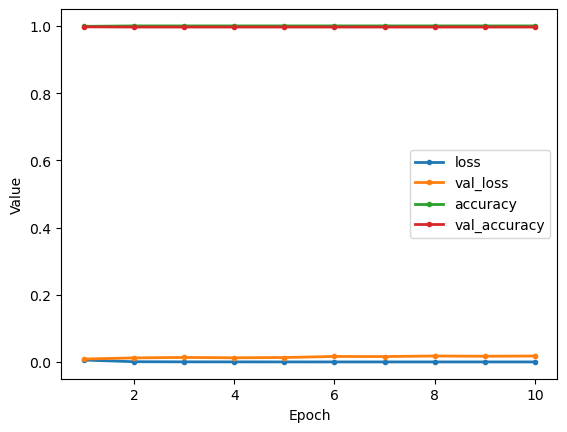

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/71 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step

 6/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

41/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

46/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

51/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

56/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

61/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


 1/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step

 6/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

41/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

46/71 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

51/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

56/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

61/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

66/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/Dof/report_8WQZGX8D.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################